In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [39]:
print(np.__version__)

1.24.0


In [109]:



# Set the seed

np.random.seed(44)
# Parameters for the normal distribution (mean, standard deviation)
mean = [5, 5]  # Center of the cluster
std_dev = 1     # Standard deviation (spread of the cluster)

# Parameters for the uniform distribution (range)
low = -2        # Lower bound for uniform distribution
high = 4        # Upper bound for uniform distribution

# Number of points
n_normal = 500  # Number of points from the normal distribution
n_uniform = 20  # Number of points from the uniform distribution

# Generating data from the normal distribution
normal_data = np.random.normal(loc=mean, scale=std_dev, size=(n_normal, 2))

# Generating data from the uniform distribution
uniform_data_x = np.random.uniform(low, high, n_uniform)
uniform_data_y = np.random.uniform(low, high, n_uniform)
uniform_data = np.column_stack((uniform_data_x, uniform_data_y))

# Combining both datasets
data = np.vstack([normal_data, uniform_data])

# Creating DataFrame for better handling and plotting
df = pd.DataFrame(data, columns=['X', 'Y'])

In [110]:
df.head()

,X,Y
0,4.249385,6.316357
1,6.246140,3.395084
2,3.531856,3.284930
3,6.858784,5.087588
4,4.947678,5.555472


In [111]:
df.to_csv("toy_data.csv", index=False)

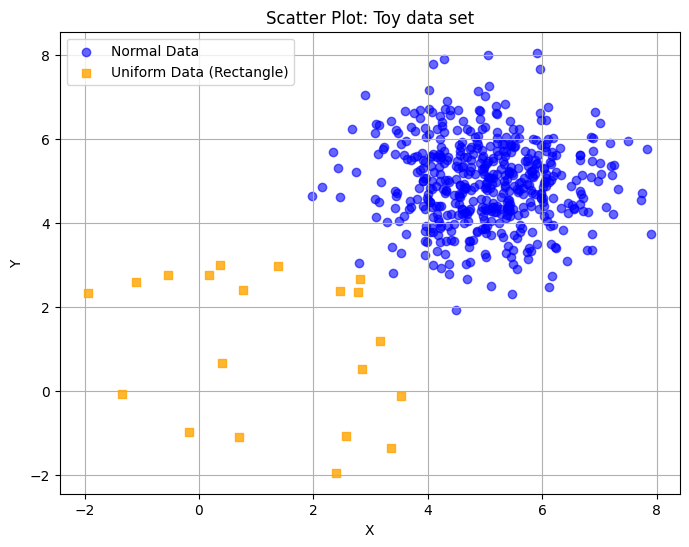

In [112]:
plt.figure(figsize=(8, 6))

# Plot normal data with circular markers
plt.scatter(normal_data[:, 0], normal_data[:, 1], color='blue', alpha=0.6, label='Normal Data')

# Plot uniform data with square markers
plt.scatter(uniform_data[:, 0], uniform_data[:, 1], color='orange', alpha=0.8, label='Uniform Data (Rectangle)', marker='s')

# Add labels, title, legend, and grid
plt.title('Scatter Plot: Toy data set')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [113]:
df

,X,Y
0,4.249385,6.316357
1,6.246140,3.395084
2,3.531856,3.284930
3,6.858784,5.087588
4,4.947678,5.555472
...,...,...
515,3.362274,-1.363084
516,1.380235,2.965639
517,0.358834,2.993117
518,2.850302,0.508650


In [114]:
def empirical_copula(x, y):
    n = len(x)
    
    # Compute ECDF for each x and y
    x_cdf = np.array([np.sum(x <= xi) / n for xi in x])
    y_cdf = np.array([np.sum(y <= yi) / n for yi in y])
    
    # Compute the joint distribution by multiplying the individual CDFs
    joint_cdf = x_cdf * y_cdf
    
    return x_cdf, y_cdf, joint_cdf

# Compute the empirical CDF and joint distribution for 'x' and 'y'
x_cdf, y_cdf, joint_cdf = empirical_copula(df['X'].values, df['Y'].values)

# Create a DataFrame to store the results
transform_data = pd.DataFrame({
    'x': df['X'],
    'U_xi': x_cdf,
    'y': df['Y'],
    'U_yi': y_cdf,
    #'P(X <= x, Y <= y)': joint_cdf
})


In [69]:
transform_data.head()

,x,U_xi,y,U_yi
0,4.249385,0.273077,6.316357,0.921154
1,6.246140,0.909615,3.395084,0.101923
2,3.531856,0.101923,3.284930,0.086538
3,6.858784,0.957692,5.087588,0.569231
4,4.947678,0.484615,5.555472,0.726923


In [70]:
joint_cdf_df = pd.DataFrame(joint_cdf, columns=['Joint_CDF'])

In [71]:
Main_df = transform_data.join(joint_cdf_df)

In [79]:
Main_df.head()

,x,U_xi,y,U_yi,Joint_CDF
0,4.249385,0.273077,6.316357,0.921154,0.251546
1,6.246140,0.909615,3.395084,0.101923,0.092711
2,3.531856,0.101923,3.284930,0.086538,0.008820
3,6.858784,0.957692,5.087588,0.569231,0.545148
4,4.947678,0.484615,5.555472,0.726923,0.352278


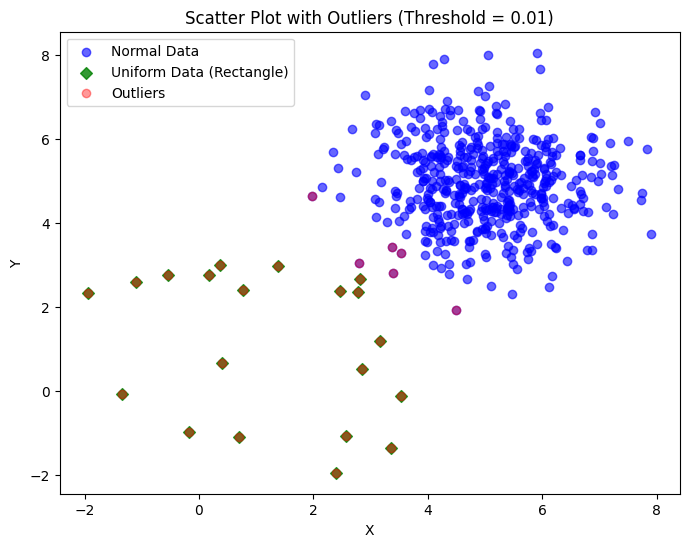

In [73]:
threshold = 0.01

# Identify outliers based on the joint CDF being less than or equal to the threshold
outliers = Main_df["Joint_CDF"] <= threshold

# Create scatter plot
plt.figure(figsize=(8, 6))

# Plot all points with a different color
#plt.scatter(df['X'], df['Y'], c='blue', label='Normal', alpha=0.6)
# Plot normal data with circular markers
plt.scatter(normal_data[:, 0], normal_data[:, 1], color='blue', alpha=0.6, label='Normal Data')

# Plot uniform data with square markers
plt.scatter(uniform_data[:, 0], uniform_data[:, 1], color='green', alpha=0.8, label='Uniform Data (Rectangle)', marker='D')
# Plot the outliers in red
plt.scatter(Main_df['x'][outliers], Main_df['y'][outliers], c='red', label='Outliers', alpha=0.4)

# Adding labels and title
plt.title('Scatter Plot with Outliers (Threshold = 0.01)')
plt.xlabel('X')
plt.ylabel('Y')

# Display legend
plt.legend()

# Show the plot
plt.show()


In [74]:
from pyod.models.copod import COPOD

In [180]:
import numpy as np
print(np.__version__)


2.2.1


In [75]:
clf = COPOD()
clf.fit(df)  # Assuming 'df' contains only numeric columns 'X' and 'Y'

# Get the predictions (0 for inliers, 1 for outliers)
df['Outlier_Labels'] = clf.labels_


In [115]:
df

,X,Y
0,4.249385,6.316357
1,6.246140,3.395084
2,3.531856,3.284930
3,6.858784,5.087588
4,4.947678,5.555472
...,...,...
515,3.362274,-1.363084
516,1.380235,2.965639
517,0.358834,2.993117
518,2.850302,0.508650


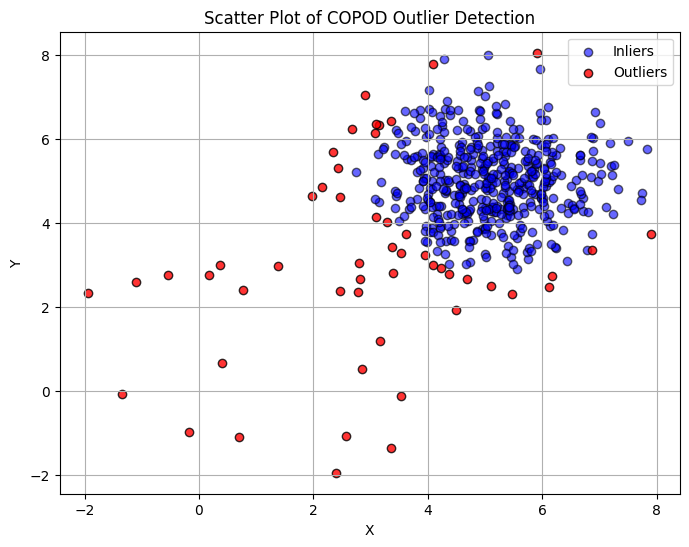

In [78]:


plt.figure(figsize=(8, 6))

# Scatter plot: inliers (Outlier_Label = 0)
plt.scatter(
    df[df['Outlier_Labels'] == 0]['X'], 
    df[df['Outlier_Labels'] == 0]['Y'], 
    c='blue', 
    label='Inliers', 
    alpha=0.6, 
    edgecolor='k'
)

# Scatter plot: outliers (Outlier_Label = 1)
plt.scatter(
    df[df['Outlier_Labels'] == 1]['X'], 
    df[df['Outlier_Labels'] == 1]['Y'], 
    c='red', 
    label='Outliers', 
    alpha=0.8, 
    edgecolor='k'
)

# Plot settings
plt.title('Scatter Plot of COPOD Outlier Detection')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [116]:
from pyod.models.abod import ABOD

In [117]:
abod = ABOD()
abod.fit(df)

# Predict outliers (1 for outliers, 0 for inliers)
outliers = abod.predict(df)

In [118]:
df['Outlier'] = outliers

In [133]:
df

,X,Y,Outlier,ABOD_Score,Rank
0,4.249385,6.316357,0,-1517.170323,148
1,6.246140,3.395084,0,-5816.298846,348
2,3.531856,3.284930,0,-19.646433,466
3,6.858784,5.087588,0,-502.804877,349
4,4.947678,5.555472,0,-3925.727526,227
...,...,...,...,...,...
515,3.362274,-1.363084,1,-0.130872,434
516,1.380235,2.965639,1,-0.455432,507
517,0.358834,2.993117,1,-2.411370,508
518,2.850302,0.508650,1,-0.258692,510


In [138]:
print(df[df["Rank"]==1])

            X         Y  Outlier   ABOD_Score  Rank
273  5.328953  5.413245        0 -2695.746859     1


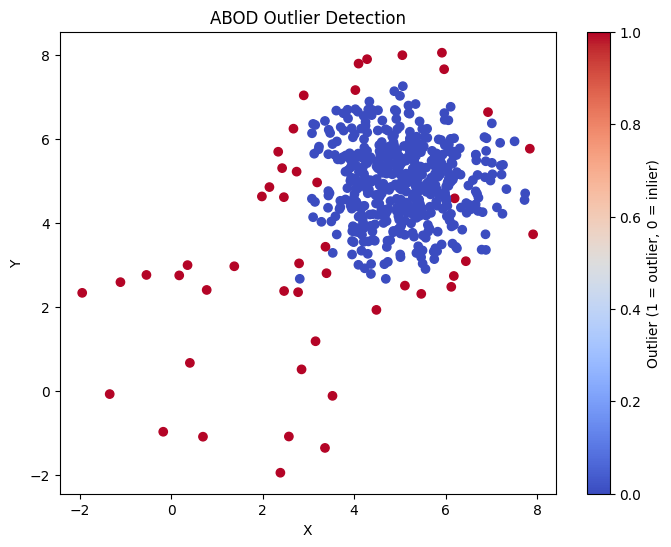

In [140]:
# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(df['X'], df['Y'], c=df['Outlier'], cmap='coolwarm', label='Data points')
plt.title('ABOD Outlier Detection')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Outlier (1 = outlier, 0 = inlier)')
plt.show()

In [124]:
abod_scores = abod.decision_function(df[["X","Y"]])

# Rank the ABOD scores (higher scores indicate more outlying)
df['ABOD_Score'] = abod_scores

In [131]:
df['Rank'] = np.argsort(abod_scores) + 1 

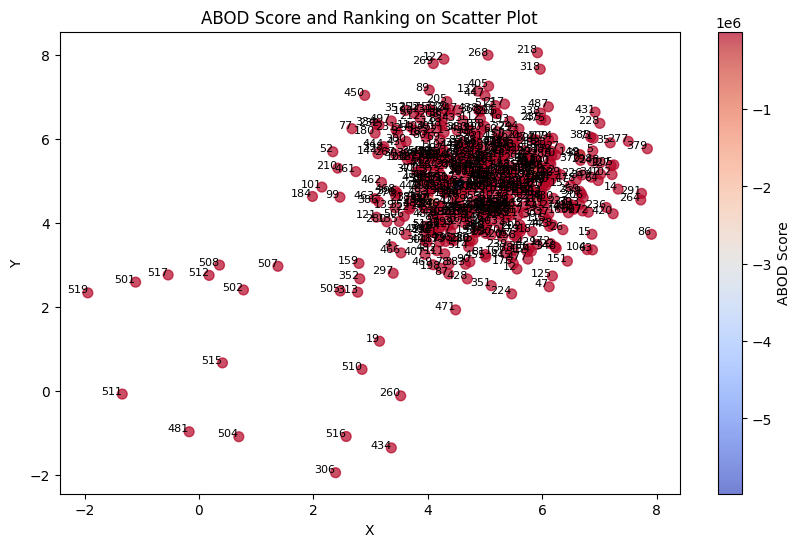

            X         Y   ABOD_Score  Rank
0    4.249385  6.316357 -1517.170323   148
1    6.246140  3.395084 -5816.298846   348
2    3.531856  3.284930   -19.646433   466
3    6.858784  5.087588  -502.804877   349
4    4.947678  5.555472 -3925.727526   227
..        ...       ...          ...   ...
515  3.362274 -1.363084    -0.130872   434
516  1.380235  2.965639    -0.455432   507
517  0.358834  2.993117    -2.411370   508
518  2.850302  0.508650    -0.258692   510
519  2.774621  2.348003    -5.824464   313

[520 rows x 4 columns]


In [132]:
plt.figure(figsize=(10, 6))

# Scatter plot with color based on the ABOD score
scatter = plt.scatter(df['X'], df['Y'], c=df['ABOD_Score'], cmap='coolwarm', s=50, alpha=0.7)

# Add colorbar to show the ABOD score scale
plt.colorbar(scatter, label='ABOD Score')

# Optionally, add labels for the points based on their rank
for i, txt in enumerate(df['Rank']):
    plt.annotate(txt, (df['X'].iloc[i], df['Y'].iloc[i]), fontsize=8, ha='right')

# Add titles and labels
plt.title('ABOD Score and Ranking on Scatter Plot')
plt.xlabel('X')
plt.ylabel('Y')

# Show the plot
plt.show()

# Display the DataFrame with ABOD scores and ranks
print(df[['X', 'Y', 'ABOD_Score', 'Rank']])

In [127]:
df

,X,Y,Outlier,ABOD_Score
0,4.249385,6.316357,0,-1517.170323
1,6.246140,3.395084,0,-5816.298846
2,3.531856,3.284930,0,-19.646433
3,6.858784,5.087588,0,-502.804877
4,4.947678,5.555472,0,-3925.727526
...,...,...,...,...
515,3.362274,-1.363084,1,-0.130872
516,1.380235,2.965639,1,-0.455432
517,0.358834,2.993117,1,-2.411370
518,2.850302,0.508650,1,-0.258692


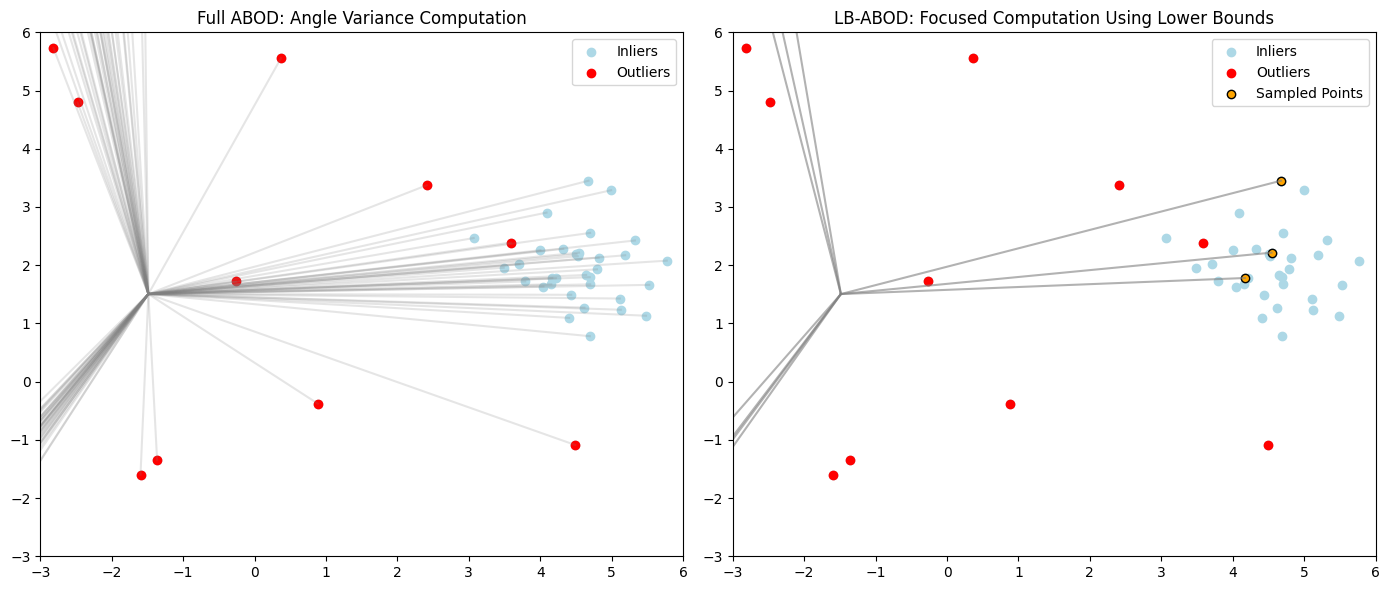

In [141]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate a toy dataset with clusters and outliers
X, _ = make_blobs(n_samples=100, centers=3, cluster_std=0.60, random_state=42)
np.random.seed(42)
outliers = np.random.uniform(low=-3, high=6, size=(10, 2))
X = np.vstack([X, outliers])

# Plotting function to illustrate LB-ABOD approximation
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Full ABOD (conceptual)
ax[0].scatter(X[:, 0], X[:, 1], c='lightblue', label='Inliers')
ax[0].scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers')
for i, point in enumerate(X):
    ax[0].plot([point[0], X[:, 0].mean()], [point[1], X[:, 1].mean()],
               color='gray', alpha=0.2)
ax[0].set_title("Full ABOD: Angle Variance Computation")
ax[0].legend()
ax[0].set_xlim(-3, 6)
ax[0].set_ylim(-3, 6)

# Subplot 2: LB-ABOD Approximation
# Highlighting lower bounds with reduced computations
sampled_points = X[np.random.choice(range(len(X)), size=10, replace=False)]
ax[1].scatter(X[:, 0], X[:, 1], c='lightblue', label='Inliers')
ax[1].scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers')
ax[1].scatter(sampled_points[:, 0], sampled_points[:, 1],
               c='orange', label='Sampled Points', edgecolors='black')
for i, point in enumerate(sampled_points):
    ax[1].plot([point[0], X[:, 0].mean()], [point[1], X[:, 1].mean()],
               color='gray', alpha=0.6)
ax[1].set_title("LB-ABOD: Focused Computation Using Lower Bounds")
ax[1].legend()
ax[1].set_xlim(-3, 6)
ax[1].set_ylim(-3, 6)

plt.tight_layout()
plt.show()